### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR, LinearSVR
import matplotlib.pyplot as plt
import seaborn as sns
import hiplot as hip

### Helper for plotting important coefficients

In [2]:
def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(True)
    ax.grid(axis='y')

### Reading the train and test datasets from the latest (date) based split

In [3]:
train = pd.read_csv('../data/temp/sampling_blind/latest/articles_train.csv')
test = pd.read_csv('../data/temp/sampling_blind/latest/articles_test.csv')

In [4]:
train[:2]

,content_id,month,day,year,date,content_source_desc,content_title_clean,content_body_clean,blind_mean_rating,blind_rating_count,blind_ratings
0,2932,11,2,2017,2017-11-02,The New York Times,A Tax Cut That Lifts the Economy? Opinions Are...,Yet if the House plan resolves some longstandi...,3.177778,45,"[4.5, 1.5, 0.5, 4.5, 1.0, 4.0, 3.5, 3.5, 1.5, ..."
1,2870,11,1,2017,2017-11-01,Fox News,"Tom Tancredo enters Colorado governor's race, ...",Former U.S. Rep. Tom Tancredo announced Tuesda...,2.375000,16,"[3.5, 4.0, 3.0, 2.5, 0.5, 3.0, 0.5, 0.5, 4.5, ..."


### Converting to lists as that is required as input to the Vectorizer

In [5]:
train_list = train['content_body_clean'].tolist()
test_list = test['content_body_clean'].tolist()

In [6]:
train_target = train['blind_mean_rating']
test_target = test['blind_mean_rating']

## Content information only

### TFIDF Vectorizer

In [7]:
tfidf = TfidfVectorizer(ngram_range=(1,3), min_df=2)

In [8]:
pipe = Pipeline((('tfidf', tfidf),
        ('regressor', Ridge())))

In [9]:
param_grid = [{'regressor':[Ridge(), Lasso(max_iter=10000)],
              'regressor__alpha':np.logspace(-3,3,13)},
              {'regressor':[LinearSVR(max_iter=10000)],
              'regressor__C':np.logspace(-2,3,8)},
             {'regressor':[GradientBoostingRegressor()],
             'regressor__max_depth':[2,3,4,5]}]

In [10]:
# param_grid = [{'regressor':[Ridge()],
#               'regressor__alpha':np.logspace(-3,3,13)},
#               {'regressor':[LinearSVR(max_iter=10000)],
#               'regressor__C':np.logspace(-2,3,8)}]

### Grid searching the models with a 5 fold CV

In [11]:
grid = GridSearchCV(pipe, param_grid, scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'], 
                    cv=5, verbose=2, refit='neg_mean_absolute_error')

In [12]:
grid.fit(train_list, train_target)

Fitting 5 folds for each of 38 candidates, totalling 190 fits
[CV] regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.001 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.001, total=   6.3s
[CV] regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.001 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV]  regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.001, total=   6.4s
[CV] regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.001 
[CV]  regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.001, total=   6.4s
[CV] regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.001 
[CV]  regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.001, total=   6.3s
[CV] regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      norm

[CV]  regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.1, total=   5.8s
[CV] regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.1 
[CV]  regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.1, total=   5.5s
[CV] regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.31622776601683794 
[CV]  regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.31622776601683794, total=   5.8s
[CV] regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max

[CV]  regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=31.622776601683793, total=   5.9s
[CV] regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=31.622776601683793 
[CV]  regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=31.622776601683793, total=   5.8s
[CV] regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=31.622776601683793 
[CV]  regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=31.622776601683793, total=   5.8s
[CV] regressor=Ridge(alph

[CV]  regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), regressor__alpha=0.001, total=   7.6s
[CV] regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), regressor__alpha=0.001 
[CV]  regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), regressor__alpha=0.001, total=   7.6s
[CV] regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), regressor__alpha=0.0031622776601683794 
[C

[CV]  regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), regressor__alpha=0.1, total=   6.4s
[CV] regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), regressor__alpha=0.1 
[CV]  regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), regressor__alpha=0.1, total=   6.4s
[CV] regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), regressor__alpha=0.1 
[CV]  regressor=Lasso(alph

[CV]  regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), regressor__alpha=3.1622776601683795, total=   6.0s
[CV] regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), regressor__alpha=3.1622776601683795 
[CV]  regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), regressor__alpha=3.1622776601683795, total=   6.0s
[CV] regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), reg

[CV]  regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), regressor__alpha=100.0, total=   6.0s
[CV] regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), regressor__alpha=316.22776601683796 
[CV]  regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), regressor__alpha=316.22776601683796, total=   6.4s
[CV] regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), regressor__alpha

[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=0.05179474679231213, total=   6.1s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=0.05179474679231213 
[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=0.05179474679231213, total=   6.6s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=0.05179474679231213 
[CV]  regr

[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=7.196856730011521, total=   7.7s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=7.196856730011521 
[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=7.196856730011521, total=   6.9s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=37.27593720314942 
[CV]  regressor=Li

/Users/harish/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=1000.0, total=  52.3s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=1000.0 


/Users/harish/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=1000.0, total=  50.8s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=1000.0 


/Users/harish/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=1000.0, total=  47.1s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=1000.0 


/Users/harish/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=1000.0, total=  50.3s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=1000.0 


/Users/harish/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=1000.0, total=  47.4s
[CV] regressor=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), regressor__max_depth=2 
[CV]  regressor=GradientBoostingRegressor(alpha=0.9,

[CV]  regressor=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), regressor__max_depth=3, total=  42.0s
[CV] regressor=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_d

[CV]  regressor=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), regressor__max_depth=4, total=  49.8s
[CV] regressor=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_d

[CV]  regressor=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), regressor__max_depth=5, total= 1.1min
[CV] regressor=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_d

[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed: 39.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=(('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=2,
                                                        ngram_range=(1, 3),
                                                        n

In [13]:
cv_results = pd.DataFrame(grid.cv_results_)

In [14]:
cv_results['regressor'] = cv_results['param_regressor'].apply(lambda x:x.__class__.__name__)

In [41]:
# cv_results.to_csv('cv_results_without_source.csv', index=False)
# cv_results = pd.read_csv('cv_results_without_source.csv')

#### Visualizing performance on test set across different hyperparameters - run this in the notebook with cv_results in memory

In [81]:
# hip.Experiment.from_iterable(cv_results[['regressor', 'param_regressor__alpha', 'param_regressor__C', 'param_regressor__max_depth', 'mean_test_r2', 'mean_test_neg_mean_absolute_error', 'mean_test_neg_root_mean_squared_error', 'rank_test_neg_root_mean_squared_error']].to_dict('records')).display(force_full_width=False)

In [16]:
grid.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=2, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('regressor',
                 LinearSVR(C=1.3894954943731375, dual=True, epsilon=0.0,
                           fit_intercept=True, intercept_scaling=1.0

### Test Predictions

In [17]:
print(f"Mean Absolute Error on the Test Set: {-grid.score(test_list, test_target):0.2f}")

Mean Absolute Error on the Test Set: 0.73


In [18]:
test_pred = grid.predict(test_list)

### Plotting test predictions vs actuals

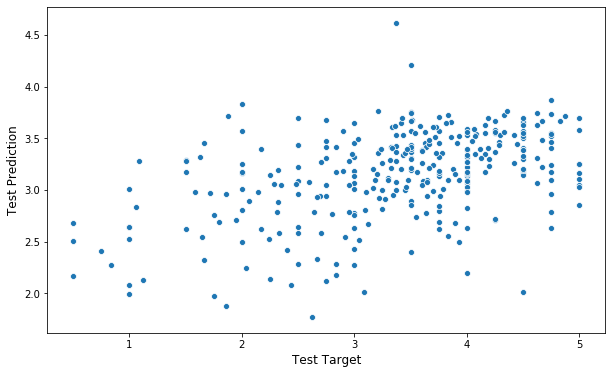

In [19]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=test_target, y=test_pred)
plt.xlabel('Test Target', fontsize=12)
plt.ylabel('Test Prediction', fontsize=12)
plt.show()

### Prediction Performance on the test set

In [20]:
test_pred_pd = pd.DataFrame(test_pred, columns=['test_pred'])
test_pred_pd['test_target'] = test_target

In [21]:
test_pred_pd['perc_error'] = abs(test_pred-test_target)/test_target
test_pred_pd['abs_error'] = abs(test_pred-test_target)

In [22]:
test_pred_pd = pd.merge(test, test_pred_pd, left_index=True, right_index=True)

In [23]:
test_pred_pd['std'] = test_pred_pd['blind_ratings'].apply(lambda x:np.std(eval(x)))

### Plotting Error magnitude against number of blind ratings

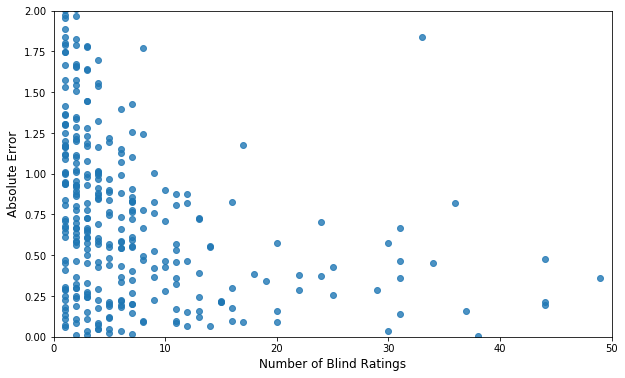

In [24]:
plt.figure(figsize=(10,6))
plt.scatter(test_pred_pd['blind_rating_count'], test_pred_pd['abs_error'], alpha=0.8)
plt.xlabel('Number of Blind Ratings', fontsize=12)
plt.ylabel('Absolute Error', fontsize=12)
plt.xlim(0,50)
plt.ylim(0,2)
plt.show()

### Test performance by number of blind ratings available

In [25]:
cm = sns.light_palette("red", as_cmap=True)

In [26]:
test_pred_pd['bin'] = pd.cut(test_pred_pd['blind_rating_count'], bins=list(np.arange(0,21,5))+[1000])

In [27]:
test_pred_bins = test_pred_pd.groupby('bin').agg({'abs_error':['count', 'median']}).reset_index()
test_pred_bins.columns = ['blind_rating_count', 'num_of_articles', 'median_abs_error']

In [28]:
test_pred_bins.style.background_gradient(subset=['median_abs_error'], cmap=cm)

,blind_rating_count,num_of_articles,median_abs_error
0,"(0, 5]",193,0.871963
1,"(5, 10]",63,0.584884
2,"(10, 15]",27,0.360592
3,"(15, 20]",11,0.301327
4,"(20, 1000]",32,0.287335


In [29]:
test_pred_bins = test_pred_pd.groupby('bin').agg({'perc_error':['count', 'median']}).reset_index()
test_pred_bins.columns = ['blind_rating_count', 'num_of_articles', 'median_perc_error']

In [30]:
test_pred_bins.style.background_gradient(subset=['median_perc_error'], cmap=cm)

,blind_rating_count,num_of_articles,median_perc_error
0,"(0, 5]",193,0.216302
1,"(5, 10]",63,0.17696
2,"(10, 15]",27,0.110181
3,"(15, 20]",11,0.093616
4,"(20, 1000]",32,0.107814


### Top Coefficients

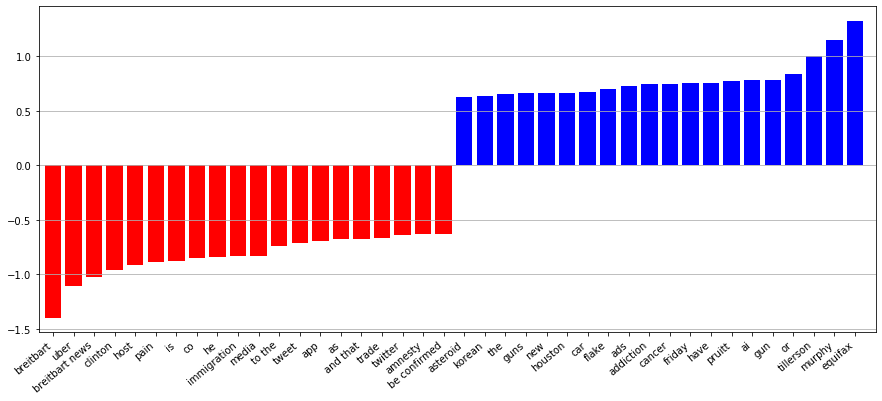

In [31]:
plt.figure(figsize=(15, 6))
plot_important_features(grid.best_estimator_.named_steps['regressor'].coef_.ravel(), np.array(grid.best_estimator_.named_steps['tfidf'].get_feature_names()), top_n=20, rotation=40)
ax = plt.gca()

## Content plus source information

**Question: How do I include side information like source to the tfidf output? I want to include the article source but the pipeline input is a list of lists (not a dataframe where I can apply certain transforms to certain subsets of columns)**

In [32]:
tfidf_src = TfidfVectorizer(ngram_range=(1,3), min_df=2)
ohe = OneHotEncoder(handle_unknown='ignore')

### TFIDF Vectorizer

In [33]:
tfidf_X_train = tfidf_src.fit_transform(train_list)
tfidf_X_test = tfidf_src.transform(test_list)

### One hot encoder for source

In [34]:
ohe_X_train = ohe.fit_transform(train[['content_source_desc']])
ohe_X_test = ohe.transform(test[['content_source_desc']])

### Stacking the two together

In [35]:
tfidf_ohe_X_train = np.hstack([tfidf_X_train.toarray(), ohe_X_train.toarray()])
tfidf_ohe_X_test = np.hstack([tfidf_X_test.toarray(), ohe_X_test.toarray()])

In [36]:
pipe_src = Pipeline([('regressor', Ridge())])

In [37]:
# param_grid_src = [{'regressor':[Ridge()],
#               'regressor__alpha':np.logspace(-3,3,13)},
#                   {'regressor':[LinearSVR(max_iter=10000)],
#               'regressor__C':np.logspace(-2,3,8)},
#                   {'regressor':[GradientBoostingRegressor()],
#              'regressor__max_depth':[2,3,4,5]}]

In [44]:
param_grid_src = [{'regressor':[Ridge()],
              'regressor__alpha':np.logspace(-3,3,13)},
              {'regressor':[LinearSVR(max_iter=10000)],
              'regressor__C':np.logspace(-2,3,8)}]

### Grid searching the models with a 5 fold CV

In [48]:
grid_src = GridSearchCV(pipe_src, param_grid_src, scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'], 
                    cv=5, verbose=2, refit='neg_mean_absolute_error')

In [49]:
grid_src.fit(tfidf_ohe_X_train, train_target)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.001 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.001, total=   7.7s
[CV] regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.001 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV]  regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.001, total=   6.1s
[CV] regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.001 
[CV]  regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.001, total=   5.9s
[CV] regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.001 
[CV]  regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.001, total=   6.0s
[CV] regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      norm

[CV]  regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.1, total=   5.9s
[CV] regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.1 
[CV]  regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.1, total=   6.0s
[CV] regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.31622776601683794 
[CV]  regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=0.31622776601683794, total=   6.0s
[CV] regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max

[CV]  regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=31.622776601683793, total=   6.0s
[CV] regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=31.622776601683793 
[CV]  regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=31.622776601683793, total=   6.1s
[CV] regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=31.622776601683793 
[CV]  regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), regressor__alpha=31.622776601683793, total=   6.1s
[CV] regressor=Ridge(alph

[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=0.01, total=   2.1s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=0.01 
[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=0.01, total=   2.0s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=0.05179474679231213 
[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0

[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=7.196856730011521, total=   3.7s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=7.196856730011521 
[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=7.196856730011521, total=   3.7s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=7.196856730011521 
[CV]  regressor=Li

/Users/harish/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=193.06977288832496, total=  39.6s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=193.06977288832496 


/Users/harish/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=193.06977288832496, total=  40.2s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=193.06977288832496 


/Users/harish/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=193.06977288832496, total=  38.7s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=193.06977288832496 


/Users/harish/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=193.06977288832496, total=  43.2s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=193.06977288832496 
[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=193.06977288832496, total=  29.1s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=1000.0 


/Users/harish/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=1000.0, total=  42.4s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=1000.0 


/Users/harish/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=1000.0, total=  41.2s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=1000.0 


/Users/harish/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=1000.0, total=  39.0s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=1000.0 


/Users/harish/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=1000.0, total=  40.6s
[CV] regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=1000.0 


/Users/harish/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  regressor=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0), regressor__C=1000.0, total=  39.0s


[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed: 15.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('regressor',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'regressor': [Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=Fa...
                                                  max_iter=10000,
                                                  random_state=None, tol=0.0001,
                                                  verbose=0)

In [50]:
cv_results_src = pd.DataFrame(grid_src.cv_results_)

In [51]:
cv_results_src['regressor'] = cv_results_src['param_regressor'].apply(lambda x:x.__class__.__name__)

In [52]:
# cv_results_src.to_csv('cv_results_with_source.csv', index=False)
# cv_results_src = pd.read_csv('cv_results_with_source.csv')

#### Visualizing performance on test set across different hyperparameters - run this in the notebook with cv_results in memory

In [80]:
# hip.Experiment.from_iterable(cv_results_src[['regressor', 'param_regressor__alpha', 'param_regressor__C', 'mean_test_r2', 'mean_test_neg_mean_absolute_error', 'mean_test_neg_root_mean_squared_error', 'rank_test_neg_root_mean_squared_error']].to_dict('records')).display(force_full_width=False)

In [54]:
grid_src.best_estimator_

Pipeline(memory=None,
         steps=[('regressor',
                 LinearSVR(C=1.3894954943731375, dual=True, epsilon=0.0,
                           fit_intercept=True, intercept_scaling=1.0,
                           loss='epsilon_insensitive', max_iter=10000,
                           random_state=None, tol=0.0001, verbose=0))],
         verbose=False)

### Test Predictions

In [55]:
print(f"Mean Absolute Error on the Test Set: {-grid_src.score(tfidf_ohe_X_test, test_target):0.2f}")

Mean Absolute Error on the Test Set: 0.69


In [56]:
test_pred_src = grid_src.predict(tfidf_ohe_X_test)

### Plotting test predictions vs actuals

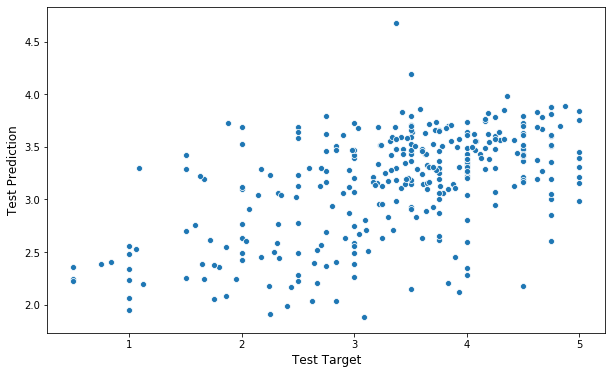

In [57]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=test_target, y=test_pred_src)
plt.xlabel('Test Target', fontsize=12)
plt.ylabel('Test Prediction', fontsize=12)
plt.show()

### Prediction Performance on the test set

In [58]:
test_pred_pd = pd.DataFrame(test_pred_src, columns=['test_pred'])
test_pred_pd['test_target'] = test_target

In [59]:
test_pred_pd['perc_error'] = abs(test_pred_src-test_target)/test_target
test_pred_pd['abs_error'] = abs(test_pred_src-test_target)

In [60]:
test_pred_pd = pd.merge(test, test_pred_pd, left_index=True, right_index=True)

In [61]:
test_pred_pd['std'] = test_pred_pd['blind_ratings'].apply(lambda x:np.std(eval(x)))

### Plotting Error magnitude against number of blind ratings

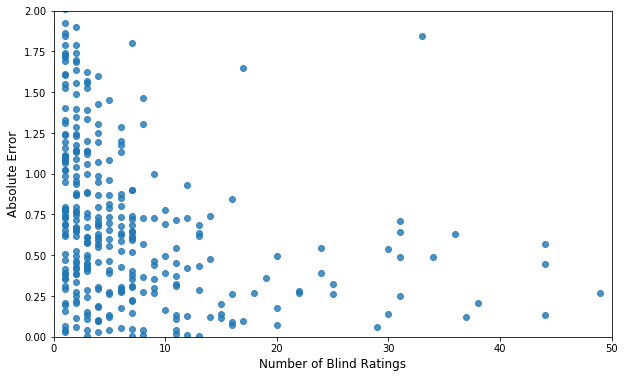

In [62]:
plt.figure(figsize=(10,6))
plt.scatter(test_pred_pd['blind_rating_count'], test_pred_pd['abs_error'], alpha=0.8)
plt.xlabel('Number of Blind Ratings', fontsize=12)
plt.ylabel('Absolute Error', fontsize=12)
plt.xlim(0,50)
plt.ylim(0,2)
plt.show()

### Test performance by number of blind ratings available

In [63]:
cm = sns.light_palette("red", as_cmap=True)

In [64]:
test_pred_pd['bin'] = pd.cut(test_pred_pd['blind_rating_count'], bins=list(np.arange(0,21,5))+[1000])

In [65]:
test_pred_bins = test_pred_pd.groupby('bin').agg({'abs_error':['count', 'median']}).reset_index()
test_pred_bins.columns = ['blind_rating_count', 'num_of_articles', 'median_abs_error']

In [66]:
test_pred_bins.style.background_gradient(subset=['median_abs_error'], cmap=cm)

,blind_rating_count,num_of_articles,median_abs_error
0,"(0, 5]",193,0.749775
1,"(5, 10]",63,0.566237
2,"(10, 15]",27,0.325732
3,"(15, 20]",11,0.262372
4,"(20, 1000]",32,0.275432


In [67]:
test_pred_bins = test_pred_pd.groupby('bin').agg({'perc_error':['count', 'median']}).reset_index()
test_pred_bins.columns = ['blind_rating_count', 'num_of_articles', 'median_perc_error']

In [68]:
test_pred_bins.style.background_gradient(subset=['median_perc_error'], cmap=cm)

,blind_rating_count,num_of_articles,median_perc_error
0,"(0, 5]",193,0.198289
1,"(5, 10]",63,0.149978
2,"(10, 15]",27,0.107296
3,"(15, 20]",11,0.0753138
4,"(20, 1000]",32,0.0925476


### Top Coefficients

In [69]:
feat_names = np.hstack([np.array(tfidf_src.get_feature_names()), ohe.get_feature_names()])

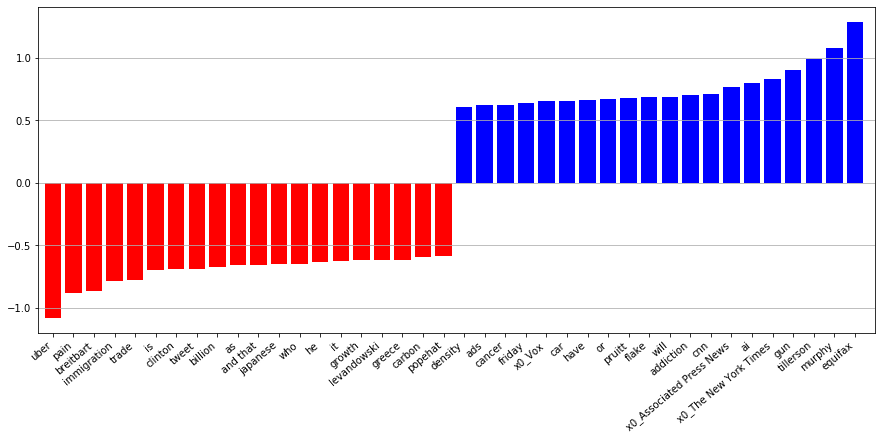

In [70]:
plt.figure(figsize=(15, 6))
plot_important_features(grid_src.best_estimator_.named_steps['regressor'].coef_, feat_names, top_n=20, rotation=40)
ax = plt.gca()

### Printing Grid Search Results

#### Without Source

In [75]:
cm = sns.light_palette("green", as_cmap=True)

In [79]:
cv_results[['regressor', 'param_regressor__alpha', 'param_regressor__C', 'param_regressor__max_depth', 'mean_test_r2','mean_test_neg_mean_absolute_error', 'mean_test_neg_root_mean_squared_error', 'rank_test_neg_root_mean_squared_error']].style.background_gradient(cmap=cm)

,regressor,param_regressor__alpha,param_regressor__C,param_regressor__max_depth,mean_test_r2,mean_test_neg_mean_absolute_error,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,Ridge,0.001,nan,nan,0.139827,-0.619486,-0.810238,10
1,Ridge,0.00316228,nan,nan,0.140187,-0.619343,-0.810081,9
2,Ridge,0.01,nan,nan,0.141483,-0.618818,-0.80954,8
3,Ridge,0.0316228,nan,nan,0.144993,-0.617363,-0.808048,6
4,Ridge,0.1,nan,nan,0.152929,-0.613954,-0.80469,4
5,Ridge,0.316228,nan,nan,0.165421,-0.608764,-0.799496,3
6,Ridge,1,nan,nan,0.170884,-0.60672,-0.797853,2
7,Ridge,3.16228,nan,nan,0.150533,-0.61522,-0.808083,7
8,Ridge,10,nan,nan,0.103623,-0.635167,-0.82955,20
9,Ridge,31.6228,nan,nan,0.0510855,-0.655809,-0.852176,23


#### With Source

In [78]:
cv_results_src[['regressor', 'param_regressor__alpha', 'param_regressor__C', 'mean_test_r2','mean_test_neg_mean_absolute_error', 'mean_test_neg_root_mean_squared_error', 'rank_test_neg_root_mean_squared_error']].style.background_gradient(cmap=cm)

,regressor,param_regressor__alpha,param_regressor__C,mean_test_r2,mean_test_neg_mean_absolute_error,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,Ridge,0.001,nan,0.16476,-0.606054,-0.798136,14
1,Ridge,0.00316228,nan,0.165076,-0.605961,-0.797989,13
2,Ridge,0.01,nan,0.165982,-0.605668,-0.797569,11
3,Ridge,0.0316228,nan,0.168434,-0.604664,-0.796433,10
4,Ridge,0.1,nan,0.17441,-0.60178,-0.793671,8
5,Ridge,0.316228,nan,0.184983,-0.59673,-0.788779,6
6,Ridge,1,nan,0.193668,-0.594107,-0.78476,3
7,Ridge,3.16228,nan,0.191875,-0.59739,-0.785746,4
8,Ridge,10,nan,0.185435,-0.602008,-0.789308,7
9,Ridge,31.6228,nan,0.178312,-0.607394,-0.793902,9
